### **1. Plant Disease Detection**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **1.1. Import Required Libraries**



In [ ]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

#### **1.2. Test-Train Data**
**Split the dataset**

In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="/content/drive/MyDrive/Colab Notebooks/dataset/Plant Leafs/train"
test_dir="/content/drive/MyDrive/Colab Notebooks/dataset/Plant Leafs/val"

In [ ]:
 #train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*"))
#test file image count
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

9 Classes
8115 Train images
869 Test images


#### **1.3. ImageDataGenerator**

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 8115 images belonging to 9 classes.
Found 869 images belonging to 9 classes.


#### **1.4. CNN Model**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu',name="conv2d_1"))
model.add(MaxPooling2D(pool_size=(3, 3),name="max_pooling2d_1"))
model.add(Conv2D(32, (3, 3),activation='relu',name="conv2d_2"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_2"))
model.add(Conv2D(64, (3, 3),activation='relu',name="conv2d_3"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_3"))
model.add(Flatten(name="flatten_1"))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)       

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 869 images belonging to 9 classes.


In [ ]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
history1 = model.fit(
    train_generator,#egitim verileri
    steps_per_epoch=None,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True
    )

Epoch 1/2
254/254 [==============================] - 1053s 4s/step - loss: 0.6889 - accuracy: 0.7641 - val_loss: 0.5566 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 2/2
254/254 [==============================] - 649s 3s/step - loss: 0.3023 - accuracy: 0.8949 - val_loss: 0.2569 - val_accuracy: 0.9114 - lr: 0.0010


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_Cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### **1.5. VGG16 Modeli**


In [ ]:
def create_Base_model_from_VGG16():
    model = VGG16(
        weights = "imagenet",
        include_top=False,
        input_shape = (224,224, 3)
        )
    for layer in model.layers:
      layer.trainable = False
    return model
create_Base_model_from_VGG16().summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def add_custom_layers():
    model = create_Base_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    # creating the final model
    final_model = tf.keras.models.Model(
        inputs = model.input,
        outputs = predictions)

    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return final_model

add_custom_layers().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir, # same directory as training data
                       target_size=(224, 224),
                       batch_size=32)

Found 869 images belonging to 9 classes.


In [ ]:
model_from_vgg16 = add_custom_layers()
history2 = model_from_vgg16.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    use_multiprocessing=False,
    shuffle=True
    )

Epoch 1/2
254/254 [==============================] - 5274s 21s/step - loss: 0.3992 - accuracy: 0.9015 - val_loss: 0.1211 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 2/2
254/254 [==============================] - 5200s 20s/step - loss: 0.0644 - accuracy: 0.9779 - val_loss: 0.0687 - val_accuracy: 0.9724 - lr: 0.0010


In [ ]:
model_from_vgg16.save('/content/drive/MyDrive/Colab Notebooks/Model/model_VGG16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


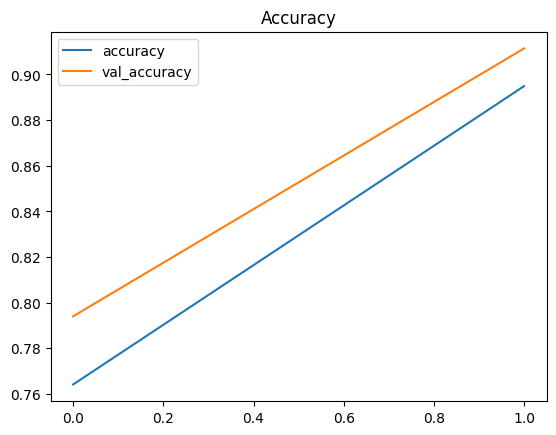

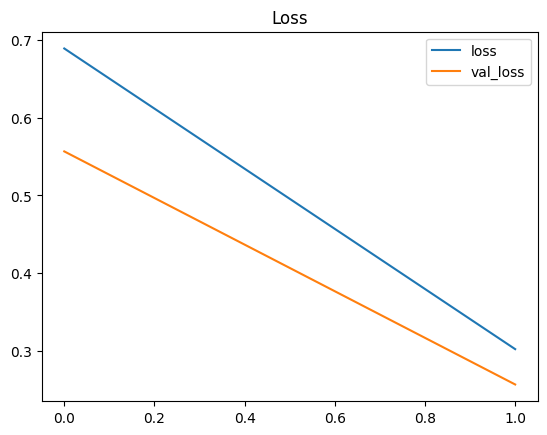

In [ ]:
pd.DataFrame(history1.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history1.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

### **2.Testing the saved model**

**2.1. VGG16 Model**

In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg16=load_model('/content/drive/MyDrive/Colab Notebooks/Model/plant_disease_Cnn.h5')

1/1 [==============================] - 0s 44ms/step
Apple___Black_rot


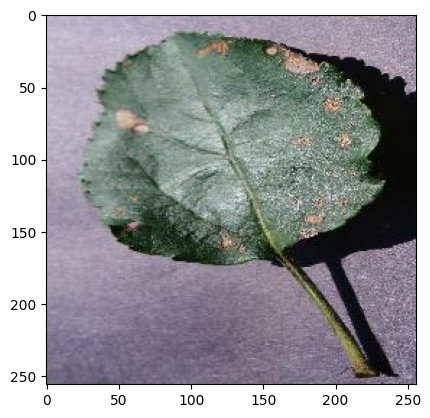

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='/content/drive/MyDrive/Colab Notebooks/dataset/Plant Leafs/val/Apple___Black_rot/0b8dabb7-5f1b-4fdc-b3fa-30b289707b90___JR_FrgE.S 3047.JPG'
result_vgg16 = model_vgg16.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(result_vgg16,axis=1)
print(classes[classresult[0]])